# Double Jet

With various grid sizes

In [1]:
from gpuocean.SWEsimulators import ModelErrorKL, CDKLM16
from gpuocean.utils import Common, IPythonMagic

from importlib import reload

import numpy as np
import copy
import pycuda.driver as cuda
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"


In [2]:
%cuda_context_handler gpu_ctx

In [3]:
gpu_stream = cuda.Stream()

In [4]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))

Get initial arguments from class

In [5]:
from gpuocean.utils import DoubleJetCase

Two-level ensemble

In [6]:
doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=512, nx=1024)
doubleJetCase_args, doubleJetCase_init, doubleJetCase_meargs = doubleJetCase.getInitConditions()

In [7]:
coarse_doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=256, nx=512)
coarse_doubleJetCase_args, coarse_doubleJetCase_init, _ = coarse_doubleJetCase.getInitConditions()

In [8]:
doubleJetCase_meargs = {
                            "basis_x_start": 2, 
                            "basis_x_end": 8,
                            "basis_y_start": 1,
                            "basis_y_end": 7,

                            "kl_decay": 1.25,
                            "kl_scaling": 0.025,
                            }

sim_model_error_time_step = 60.0                        

In [9]:
ML_Nes = [100, 50]
doubleJetCase_args_list = [coarse_doubleJetCase_args, doubleJetCase_args]
doubleJetCase_init_list = [coarse_doubleJetCase_init, doubleJetCase_init]

In [10]:
mekls = []
for l_idx in range(len(doubleJetCase_args_list)): 
    grid_args = {key: doubleJetCase_args_list[l_idx][key] for key in ('nx', 'ny', 'dx', 'dy', 'gpu_ctx', 'boundary_conditions')}
    mekls.append( ModelErrorKL.ModelErrorKL(gpu_stream=gpu_stream, **grid_args, **doubleJetCase_meargs) )

In [11]:
## MultiLevel ensemble
ML_ensemble = []

# 0-level
lvl_ensemble = []
for i in range(ML_Nes[0]):
    if i % 100 == 0: print(i)
    sim = CDKLM16.CDKLM16(**doubleJetCase_args_list[0], **doubleJetCase_init_list[0]) 

    sim.model_error = mekls[0]
    sim.model_time_step = sim_model_error_time_step
    lvl_ensemble.append( sim )

ML_ensemble.append(lvl_ensemble)

# diff-levels
for l_idx in range(1,len(ML_Nes)):
    print(l_idx)
    lvl_ensemble0 = []
    lvl_ensemble1 = []
    
    for e in range(ML_Nes[l_idx]):
        sim0 = CDKLM16.CDKLM16(**doubleJetCase_args_list[l_idx], **doubleJetCase_init_list[l_idx]) 
        sim1 = CDKLM16.CDKLM16(**doubleJetCase_args_list[l_idx-1], **doubleJetCase_init_list[l_idx-1])

        sim0.model_error = mekls[l_idx]
        sim1.model_error = mekls[l_idx-1]

        sim0.model_time_step = sim_model_error_time_step
        sim1.model_time_step = sim_model_error_time_step

        lvl_ensemble0.append(sim0)
        lvl_ensemble1.append(sim1)
    
    ML_ensemble.append([lvl_ensemble0,lvl_ensemble1])

0
1


In [12]:
from gpuocean.ensembles import MultiLevelOceanEnsemble
MLOceanEnsemble = MultiLevelOceanEnsemble.MultiLevelOceanEnsemble(ML_ensemble)

Generate observations

In [13]:
from utils.DoubleJetParameters import * 

In [14]:
truth = CDKLM16.CDKLM16(**doubleJetCase_args, **doubleJetCase_init)
truth.updateDt()
truth.setKLModelError(**doubleJetCase_meargs)
truth.model_time_step = sim_model_error_time_step

# truth.dataAssimilationStep(6*60*60)

In [15]:
true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)
obses = np.zeros((len(obs_xs),3))
for h, [obs_x, obs_y] in enumerate(zip(obs_xs, obs_ys)):
    Hx, Hy = MLOceanEnsemble.obsLoc2obsIdx(obs_x, obs_y)
    obses[h] = [true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]] + np.random.normal(0,R)

Data Assimilation

In [16]:
prior = copy.deepcopy(MLOceanEnsemble.download())

In [17]:
from gpuocean.dataassimilation import MLEnKFOcean
MLEnKF = MLEnKFOcean.MLEnKFOcean(MLOceanEnsemble)

In [18]:
precomp_GC = []
for obs_x, obs_y in zip(obs_xs, obs_ys):
    precomp_GC.append( MLEnKF.GCweights(obs_x, obs_y, r) )

In [19]:
ML_state = MLOceanEnsemble.download()

for h, [obs_x, obs_y] in enumerate(zip(obs_xs, obs_ys)):
    print(h)
    obs = obses[h]
    
    ML_state = MLEnKF.assimilate(ML_state, obs, obs_x, obs_y, R, 
                            r=r, obs_var=slice(1,3), relax_factor=0.5, 
                            min_localisation_level=0,
                            precomp_GC=precomp_GC[h])

MLOceanEnsemble.upload(ML_state)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [20]:
posterior = copy.deepcopy(MLOceanEnsemble.download())

In [21]:
from utils.DoubleJetPlot import *

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

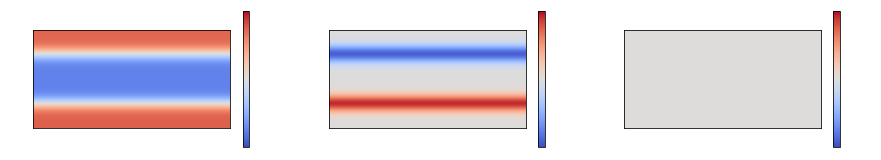

In [22]:
imshow3(MLOceanEnsemble.estimate(np.mean))

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

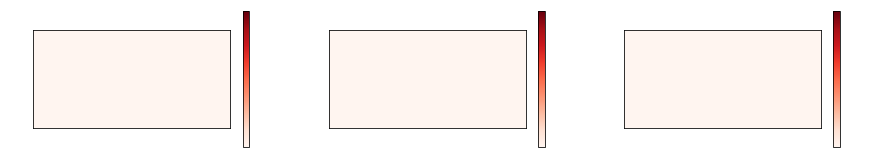

In [23]:
imshow3var(MLOceanEnsemble.estimate(np.std), eta_vlim=0.5, huv_vlim=100)